In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\user\appdata\local\temp\pip-req-build-3e6axvke
  Resolved https://github.com/tensorflow/docs to commit 881afa31a959c86c39664c1d81d00e453eddf3f2
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\User\AppData\Local\Temp\pip-req-build-3e6axvke'


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from gensim.corpora.dictionary import Dictionary as gdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import pathlib
import shutil
import tempfile
import gc

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
df_raw = pd.read_csv('IMDBDataset.csv')

In [5]:
df_raw.shape

(50000, 2)

In [6]:
df_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df_raw['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

# Data preparation

In [8]:
df = df_raw.copy()

In [9]:
# map sentiment into binary variables

binary_map =  {'negative':0, 'positive': 1}
df['sentiment'] = df['sentiment'].map(binary_map)

In [10]:
reviews_raw = df['review']

In [11]:
reviews_raw

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [12]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [13]:
def convert_lower(text):
    return text.lower()

In [14]:
df['review'] = df['review'].apply(convert_lower)

In [15]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [16]:
del df_raw
del reviews_raw
gc.collect()

0

# Tokenize to map the words into integers

In [17]:
df["review"] = df["review"].map(lambda x: x.split(' '))

In [18]:
my_dict = gdict(df['review'])

In [19]:
len(my_dict)

392053

In [20]:
my_dict.filter_extremes(no_below=1, no_above=1, keep_n=5000)

In [21]:
df["bow"] = df["review"].map(my_dict.doc2bow)

In [22]:
df.head()

,review,sentiment,bow
0,"[one, of, the, other, reviewers, has, mentione...",1,"[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3..."
1,"[a, wonderful, little, production., <br, /><br...",1,"[(0, 3), (3, 3), (5, 4), (6, 1), (8, 2), (10, ..."
2,"[i, thought, this, was, a, wonderful, way, to,...",1,"[(0, 2), (5, 6), (10, 4), (12, 1), (16, 2), (1..."
3,"[basically, there's, a, family, where, a, litt...",0,"[(0, 3), (5, 10), (8, 3), (10, 4), (12, 2), (1..."
4,"[petter, mattei's, ""love, in, the, time, of, m...",1,"[(0, 4), (3, 2), (5, 6), (6, 2), (8, 2), (10, ..."


In [23]:
df2 = pd.concat([pd.DataFrame(s).set_index(0) for s in df["bow"]], axis=1).fillna(0).T.set_index(df.index)

In [24]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,2.0,0.0,6.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df2.astype('int32')

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,3,1,1,1,1,3,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,3,0,4,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,10,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,2,0,6,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,0,0,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,2,0,0,1,0,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
49997,2,0,0,0,0,7,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,3,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df2.shape

(50000, 5000)

In [27]:
df['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [28]:
df_preprocessed = pd.concat([df2,df['sentiment']], axis=1)

In [29]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 5001 entries, 0 to sentiment
dtypes: float64(5000), int64(1)
memory usage: 1.9 GB


In [30]:
df_preprocessed.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,sentiment
0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,3.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4.0,0.0,0.0,2.0,0.0,6.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [31]:
del df
del df2
del my_dict
gc.collect()

0

## Check balance

In [32]:
df_preprocessed['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [33]:
sum_token = df_preprocessed.iloc[:, :5000].sum(axis=1)

In [34]:
df_check_token_balanced = pd.concat([sum_token, df_preprocessed['sentiment']], axis=1)

In [35]:
df_check_token_balanced.columns

Index([0, 'sentiment'], dtype='object')

In [36]:
df_check_token_balanced.iloc[-1].unique()

array([116.,   0.])

In [37]:
df_check_token_balanced.value_counts()

0       sentiment
117.0   1            212
115.0   0            210
111.0   0            207
113.0   0            202
119.0   0            197
                    ... 
740.0   0              1
741.0   1              1
743.0   1              1
744.0   1              1
1909.0  1              1
Length: 1676, dtype: int64

In [38]:
df_check_token_balanced.columns =['sum_token', 'sentiment']

In [39]:
df_check_token_balanced.head()

,sum_token,sentiment
0,248.0,1
1,133.0,1
2,140.0,1
3,117.0,0
4,193.0,1


<AxesSubplot:xlabel='sentiment', ylabel='sum_token'>

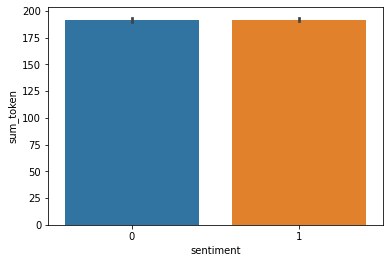

In [40]:
sns.barplot(data = df_check_token_balanced, x = "sentiment" , y ="sum_token")

<AxesSubplot:xlabel='sentiment', ylabel='sum_token'>

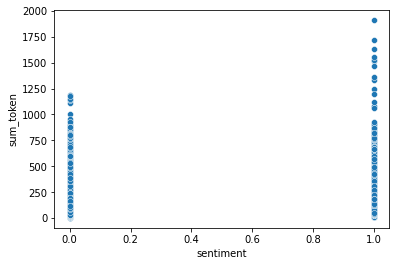

In [41]:
sns.scatterplot(data = df_check_token_balanced, x = "sentiment" , y ="sum_token")

In [42]:
# this line takes 5mins+ and may use up all memories
# df_preprocessed.to_csv('data_processed.csv', header=0)

del df_check_token_balanced
gc.collect()

# Declaring observations and targets

In [43]:
df_preprocessed.shape

(50000, 5001)

In [44]:
df_preprocessed = df_preprocessed.astype('float32')

In [45]:
#df_preprocessed.iloc[-1]

In [46]:
X = df_preprocessed.iloc[:, :5000]

In [47]:
y = df_preprocessed.iloc[:, -1].copy()

In [48]:
X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
y.head(2)

0    1.0
1    1.0
Name: sentiment, dtype: float32

In [50]:
del df_preprocessed
gc.collect()

0

# Standardize X

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train test split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size= 0.2, random_state = 42)

In [53]:
#y_train.info()

In [54]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [55]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 5000)
(10000, 5000)
(40000,)
(10000,)


In [56]:
del X_scaled,y
gc.collect()

0

# Network functions

In [57]:
BATCH_SIZE = 500
STEPS_PER_EPOCH = 40000/BATCH_SIZE

In [58]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

In [59]:
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [60]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=150),
        tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [61]:
def compile_and_fit(model, name, f_xtrain, f_ytrain, f_xval, f_yval, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()
    
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[tf.keras.metrics.BinaryCrossentropy(
                              name='binary_crossentropy'),
                              'accuracy'])

    history = model.fit(
        x = X_train,
        y = y_train,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=(X_val, y_val) ,
        callbacks=get_callbacks(name),
        verbose=2)
    
    return history

# model performance

In [62]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu',input_shape=(5000,)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

In [63]:
dict_histories = {}

In [64]:
X_train_1 = X_train[3000:]
X_val = X_train[:3000]
y_train_1 = y_train[3000:]
y_val = y_train[:3000]

In [65]:
dict_histories['ver1'] = compile_and_fit(model = model_1, name ='ver1',
                                         f_xtrain = X_train_1,f_ytrain = y_train_1, 
                                         f_xval = X_val, f_yval = y_val)

Epoch 1/10000

Epoch: 0, accuracy:0.7681,  binary_crossentropy:0.4812,  loss:0.4812,  val_accuracy:0.9097,  val_binary_crossentropy:0.2467,  val_loss:0.2467,  
.80/80 - 2s - loss: 0.4812 - binary_crossentropy: 0.4812 - accuracy: 0.7681 - val_loss: 0.2467 - val_binary_crossentropy: 0.2467 - val_accuracy: 0.9097 - 2s/epoch - 26ms/step
Epoch 2/10000
.80/80 - 1s - loss: 0.2487 - binary_crossentropy: 0.2487 - accuracy: 0.9041 - val_loss: 0.1565 - val_binary_crossentropy: 0.1565 - val_accuracy: 0.9537 - 756ms/epoch - 9ms/step
Epoch 3/10000
.80/80 - 1s - loss: 0.1712 - binary_crossentropy: 0.1712 - accuracy: 0.9370 - val_loss: 0.1073 - val_binary_crossentropy: 0.1073 - val_accuracy: 0.9690 - 737ms/epoch - 9ms/step
Epoch 4/10000
.80/80 - 1s - loss: 0.1268 - binary_crossentropy: 0.1268 - accuracy: 0.9553 - val_loss: 0.0724 - val_binary_crossentropy: 0.0724 - val_accuracy: 0.9830 - 715ms/epoch - 9ms/step
Epoch 5/10000
.80/80 - 1s - loss: 0.0925 - binary_crossentropy: 0.0925 - accuracy: 0.9686 - 

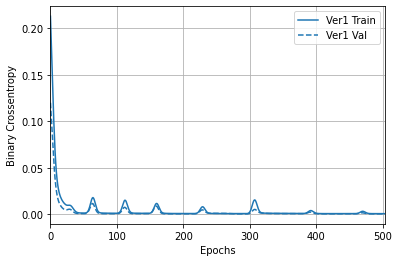

In [66]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(dict_histories)

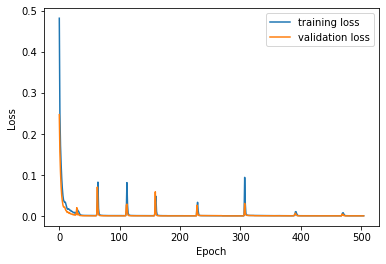

In [67]:
plt.plot(dict_histories['ver1'].history['loss'], label='training loss')
plt.plot(dict_histories['ver1'].history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [70]:
test_results = {}

test_results['model'] = model_1.evaluate(
    X_test, y_test, verbose=1)

print(test_results)

313/313 [==============================] - 2s 6ms/step - loss: 3.7382 - binary_crossentropy: 3.7382 - accuracy: 0.8591
{'model': [3.738208293914795, 3.738208293914795, 0.8590999841690063]}


In [92]:
result = model_1.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [93]:
res = tf.math.confusion_matrix(y_test, result)

In [94]:
print(res)

tf.Tensor(
[[4616  345]
 [1381 3658]], shape=(2, 2), dtype=int32)


In [95]:
# precision
3658/(1391+268)

2.2049427365883063

In [96]:
#recall 
3658/(3658+345)

0.9138146390207345